# "Or something like that": a fuzzy search application for short texts

More often when what we search for something by keywords, what we actually mean is **"show me the butterfly book, or something like that"**. Most current search application base on word matching cannot handle the case well if we type in the wrong keywords. In order to solve this "or something like that" problem. I plan to build a "fuzzy search" app that can return results base on similarity in the meaning of keywords. This is possible using the  pre-trained word to vector model and some other natural language processing (NLP) skills.

The current portotype can return **"Dragonfly in amber"** when we search for **"Butterfly in resin"**, and return **"A Knight of the Seven Kingdoms"** when we search for **"Six empire"**. 

I also show here clustering of book titles based on meaning and a potential case of "book suggestion".



## Preliminary results

Base a preliminary database of ~300 book listing (bestsellers in three category) on audible.com, I created python function that can return titles similar to a search string (what user think is the title). 

I presented two cases below where there is no match between the words in the search string and the book title.

I also visualized the similarity of some books based on the meaning of titles (and an anecdotal result that there is no simple way to distinguish books of "Erotica", "Military", or "Sci-Fi" base only on title).

The details and code of preliminary work are presented below: 

## 0. preparing data and packages

In [68]:
import numpy as np
import pandas as pd
# read
mixi = pd.read_csv('mixi2.csv')
import string
from nltk.corpus import stopwords

In [3]:
# ref: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

In [4]:
mixi.tail(3)

,title,category,makesense
295,Rendezvous with Rama,SciFi,0
296,Persepolis Rising,SciFi,0
297,FREE: Professional Integrity (A Riyria Chronic...,SciFi,0


In [5]:
mixi.head(3)

,title,category,makesense
0,Darker,Erotica,0
1,Twist Me: The Complete Trilogy,Erotica,0
2,Beautiful Bastard,Erotica,0


## 1. String processing

Remove punctuation, get words from string.

Using NLTK tools. I'm not removing stopwords here because book titles tend to have a lot of those (e.g. "If Only")

## 1. Word to vector
Downloaded the [ pretrained model trained on Google news data](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit), and unzip.

#### uncomment  the next block to run (it takes a while)

In [6]:
# from gensim.models import KeyedVectors
# filename = 'GoogleNews-vectors-negative300.bin'
# model = KeyedVectors.load_word2vec_format(filename, binary=True)


### 1.1 Some demo

In [20]:
model.similarity("love", "affection")

0.5664337518378346

In [21]:
model.similarity("love", "adore")

0.6816873802589338

In [22]:
model.similarity("love", "dog")

0.2053461595578724

### 1.2 search for a reasonable way to "average"

In [44]:
A = model.get_vector("love")
B = model.get_vector("adore")
C = model.get_vector("affection")
D = model.get_vector("grasshopper")

In [42]:
from scipy.spatial import distance
dst = distance.euclidean(A,B) # love <-> adore
dst

2.297868251800537

In [48]:
distance.euclidean(A,D)  # love <-> lizard

3.930191993713379

In [49]:
distance.euclidean(B,D)

4.334502220153809

#### We expect the distance between "love, adore" and grasshopper similar to 3.9~4.3

In [54]:
# Euclidean distance
distance.euclidean((A + B)/2,D)
# better

3.974557876586914

In [55]:
# vector distance 
distance.euclidean((A + B)/np.sqrt(sum((A + B)** 2)),D)

3.4034500122070312

#### Below, I will use euclidean distance to average the words in a title

(may be improve this step later)

## 2. String to vector

### 2.3 Convert string to vector using the google model

In [88]:
def str2vec_mean(instr, placeholder = None):
    '''
    Convert string to a vector base on average vector of the composing words.
    instr: the inpput string
    placeholder: for the non-vocabularies
    '''
    # make default placeholder
    # model.vocab
    # make a place-holder: mean of three strange words
    if placeholder is None:
        ph = (model.get_vector("Ka_wai") + model.get_vector("Chief_Carla_Piluso") + model.get_vector("Marc_Andre_Bergeron"))/3
    
    # remove punctuation
    nopunc = [char for char in instr if char not in string.punctuation]
    
    # Join the characters again to form the string.
    mystr = ''.join(nopunc).split()
    
    # Remove "the", "a", "an"
    nonsense = ["the", "a", "an"]#, "and", "to","on", "from", "in", "by"]
    mystr = [word for word in mystr if word.lower() not in nonsense]
    
    # get average vector
    L =len(mystr)
    #temp = np.zeros(300)
    if (mystr[0] in model.vocab):
        temp = model.get_vector(mystr[0])
    else:
        temp = ph
        # otherwise a vector of zeros
    if (L>1):
        for l in range(1,L):
            if (mystr[l] in model.vocab):
                temp = temp + model.get_vector(mystr[l])
            else:
                temp = temp + ph    
    out = temp/L
    
    return np.array(out.tolist())


(Does it make sense?)

In [89]:
A = str2vec_mean("Rising strong").tolist()
B = str2vec_mean("Awaken Giant Within").tolist()
C = str2vec_mean("Honeybee democracy").tolist()
distance.euclidean(A,B)

2.76395294276688

In [90]:
distance.euclidean(A,C)

3.201476728406303

In [421]:
# takes forever but interesting thing
#result = model.most_similar(positive=[], negative=['love'], topn=1)
#print(result)

### 2.2 vectorize the titles in my database

In [92]:
# empty datasheet
M = len(mixi) # number of examples
wordmat = np.zeros((M,300))
np.shape(wordmat)

(298, 300)

In [94]:
# fill in the data vectors
for m in range(M):
    A = mixi["title"][m]
    temp = str2vec_mean(A).tolist()
    wordmat[m,:] = temp

## 3. Visualize similarity

I used MDS (multidimentional scaling) to visualizes the distance relationship among titles.

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,12]
from sklearn import manifold
# I selected some title that "make sense" to visualize
makesense = mixi["makesense"] == 1
temp = wordmat[makesense, :]
subset = mixi[["title","category"]][makesense]

In [125]:
Y = manifold.MDS(n_components= 2,n_init = 100,random_state=1,dissimilarity='euclidean').fit_transform(temp)

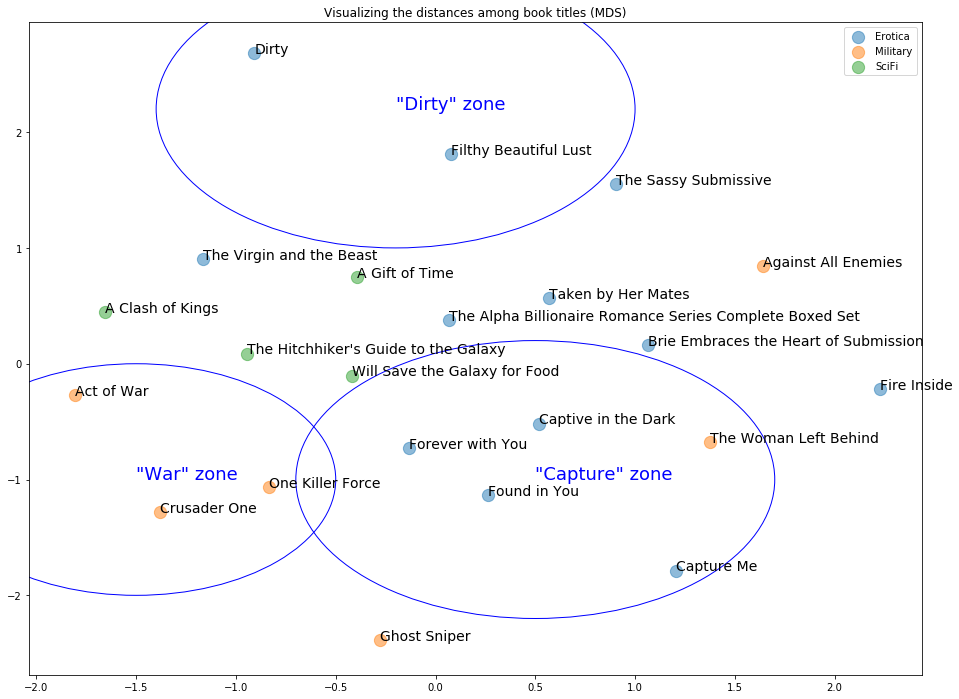

In [138]:
fig, ax = plt.subplots()
fig=plt.figure(figsize=(18, 18), dpi= 180, facecolor='w', edgecolor='k')
for i,c in enumerate(subset["category"].unique()):
    ind = (subset["category"] == c) 
#ind1 = (mixi["category"] == "Erotica") 
  #  ax.scatter(result[ind, 0], result[ind, 1],c = i,label = mixi["category"])
    ax.scatter(Y[ind, 0], Y[ind, 1], label = c, s = 150, alpha= 0.5)
   # ax.annotate(mixi["title"][9], xy=(result[9, 0], result[9, 1]))


#ax.scatter(Y[:, 0], Y[:, 1], label = mixi["category"][examples])
for i,m in enumerate(subset["title"]):
    ax.annotate(m, xy=(Y[i, 0], Y[i, 1]),fontsize = 14)
#ax.annotate(mixi["title"][1], xy=(Y[1, 0], Y[1, 1]))
ax.set_title("Visualizing the distances among book titles (MDS)")

circle2 = plt.Circle((-1.5, -1), 1, color='b', fill=False)
ax.annotate('"War" zone', xy=(-1.5, -1),fontsize = 18, color = "b")
ax.add_artist(circle2)


circle2 = plt.Circle((-0.2, 2.2), 1.2, color='b', fill=False)
ax.annotate('"Dirty" zone', xy=(-0.2, 2.2),fontsize = 18, color = "b")
ax.add_artist(circle2)


circle2 = plt.Circle((0.5, -1), 1.2, color='b', fill=False)
ax.annotate('"Capture" zone', xy=(0.5, -1),fontsize = 18, color = "b")
ax.add_artist(circle2)

ax.legend()


### Some ideas of book title clustering

On this graph above, titles with similar meaning (similar mean word vectors) are plotted closer together. We can make some sense out of the clustering:

1. there is a "War" zone on the left
2. a "Dirty" zone on top
3. and a "Cature" zone middle-bottom

Note that many titles clustered together do not have matching words ("Captive in the Dark" and "Forever with you")

## 4. The fuzzy search app

Based on the title vectorization, I build a function to search book titles base on similarity in meaning.

I then demostrated two application cases below

In [140]:
from scipy.stats import rankdata

In [146]:
def fuzzy_find(mytitle, maxshow = 10,threshhold = 2.5):
    '''
    mytitle: the user input keyword for fuzzy search
    maxshow: the max. number of result return.
    threshhold: threshhold of similarity for the "match"
    '''
    A = str2vec_mean(mytitle)
    dist = np.sqrt(np.sum((wordmat-A) ** 2,axis = 1))
    fuzzy = np.where(dist < threshhold)[0]
    L = len(fuzzy)
    if L > maxshow:
        rankF = rankdata(dist, method='min')
        fuzzy = np.where(rankF <= maxshow)[0]
    return mixi["title"][fuzzy], dist[fuzzy]

### 4.1 Find "Dragonfly in amber" by typing "Butterfly in resin"

Say, I remember someone told me about a book called "Butterfly in resin", or something like that

##### and [cannot find it on audible.com](https://www.audible.com/search/ref=a_hp_tseft?advsearchKeywords=butterfly%20in%20resin&filterby=field-keywords)

In [147]:
mytitle = "Butterfly in resin"

#### Pass this to my `fuzzy_find` function, and let it return 3 best matches

In [149]:
(result, dist) = fuzzy_find(mytitle, maxshow = 3)
result

162    Brie Masters Love in Submission: Submissive in...
174     Cincuenta Sombras de Grey [Fifty Shades of Grey]
267                                   Dragonfly in Amber
Name: title, dtype: object

#### "OK, my fault, it is actually called 'Dragonfly in Amber' ..."

(p.s.: this is a made-up case, I did not read/listen to this book)

### 4.2 Find " A Knight of the Seven Kingdoms" by typing "Six Empire"

Say, I want to find the book "A Knight of the Seven Kingdoms", but unfortunately got the wording and number wrong.


In [150]:
(result, dist) = fuzzy_find("Six Empire", maxshow = 3)
result

48       Tom Clancy: Power and Empire
260                  The Final Empire
293    A Knight of the Seven Kingdoms
Name: title, dtype: object

#### here we got "A Knight of the Seven Kingdoms" (along with some other "empire" books)

### 4.3 Book suggestion application: "Call me by your name"

#### "sorry, we don't have the item you want, but maybe you would like one of these...."


In [152]:
mytitle = "Call me by your name"

In [154]:
(result, dist) = fuzzy_find(mytitle, maxshow = 3)
result

3                         Reflected in You
26                        Forever with You
56    Tom Clancy True Faith and Allegiance
Name: title, dtype: object

In this case, "Reflected in You" and "Forever with You" seems to be good suggestions (next best things).

But the "Tom Clancy True Faith and Allegiance" may not be...


#### Here I am going to map "Call me by your name" with other items and visualize there similarity

In [163]:
res,dist = fuzzy_find(mytitle, maxshow = 3)
# visualize the matching items
ind = np.array(res.keys()) 
A = list(ind)
# and some random items in the database
B = list(np.arange(0,290, 15)[:])
ind = list(set(A) | set(B))
L = len(ind)
print("number of examples: " + str(L))

number of examples: 23


In [157]:
# compile the data for visualization:
# get target for `mytitle`
target_vec = str2vec_mean(mytitle)
# vector matrix
temp = np.zeros((len(ind)+1,300))
temp[0:len(ind),:] = wordmat[ind, :]
temp[-1,:] = target_vec

# titles
tempdb = pd.DataFrame([mytitle])
subset = mixi["title"][ind].append(tempdb)

# distances to target
dist = np.sqrt(np.sum((wordmat[ind,:]-target_vec) ** 2,axis = 1))
distemp = np.zeros(np.shape(dist)[0] +1)
distemp[0:len(dist)] = dist
subset.columns = ["title"]

#### MDS analysis for visuallization

In [159]:
Y = manifold.MDS(n_components= 2,dissimilarity='euclidean',n_init=100,random_state=1).fit_transform(temp)

Text(0.5,1,'Book titles on a 2D space: similar books are plotted closer on this graph')

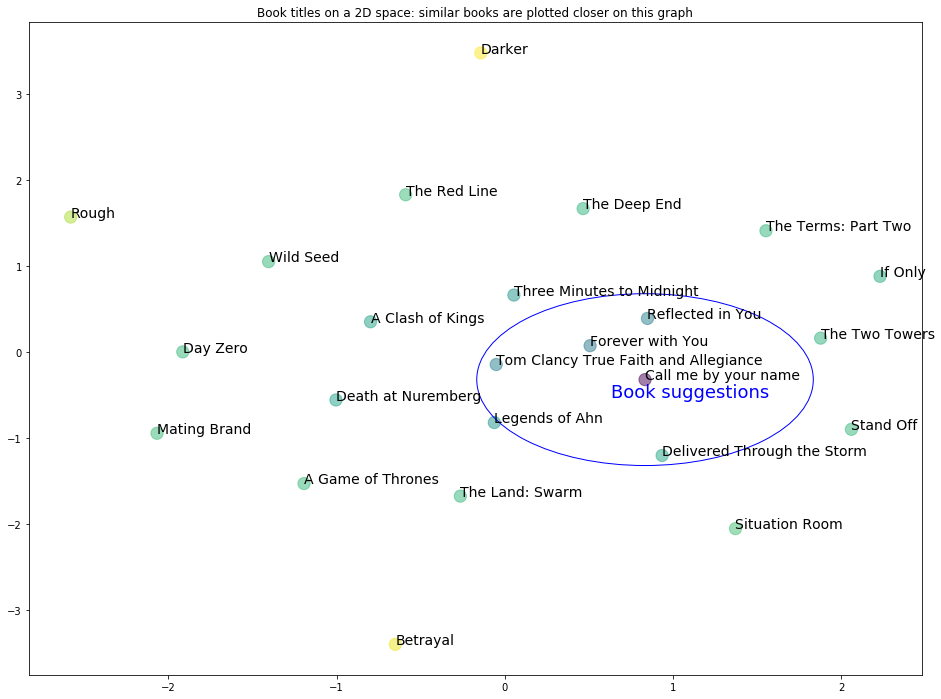

In [171]:
fig, ax = plt.subplots()
fig = plt.figure(figsize=(18, 16), dpi= 180, facecolor='w', edgecolor='k')

sc = ax.scatter(Y[:, 0], Y[:, 1], c = distemp, s = 150, alpha= 0.5)
for i,m in enumerate(subset["title"]):
    ax.annotate(m, xy=(Y[i, 0], Y[i, 1]),fontsize = 14)


circle2 = plt.Circle((Y[L, 0], Y[L, 1]), 1, color='b', fill=False)
ax.annotate('Book suggestions', xy=(Y[L, 0]-0.2, Y[L, 1]-0.2),fontsize = 18, color = "b")
ax.add_artist(circle2)

    
ax.set_title("Book titles on a 2D space: similar books are plotted closer on this graph")


### 4.4 book title clustering by Genre ("category")

This is an annecdotal result I found through exploring the data.

My preliminary database is made of ~300 books, ~100 from each of three categories: "Erotica", "Military" and "Sci-Fi".

Can we predict genre base on title?


In [168]:
#Y = manifold.MDS(n_components,dissimilarity='precomputed').fit_transform(vi_mat)
Y1 = manifold.MDS(n_components= 2,n_init=100, random_state=1, dissimilarity='euclidean').fit_transform(wordmat)

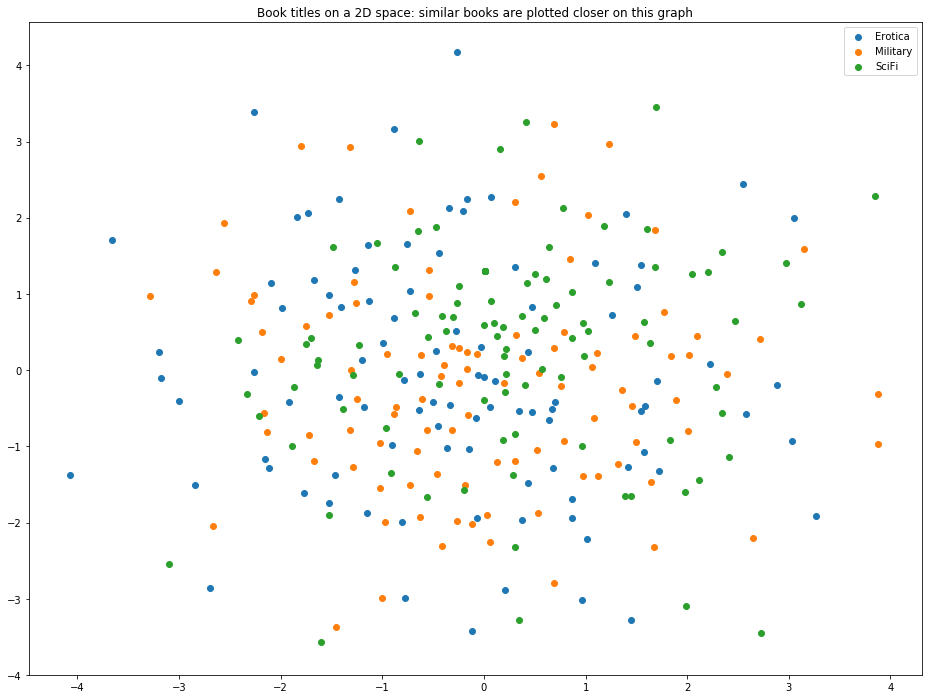

In [172]:
fig, ax = plt.subplots()
fig=plt.figure(figsize=(18, 20), dpi= 180, facecolor='w', edgecolor='k')
for i,c in enumerate(mixi["category"].unique()):
    ind = (mixi["category"] == c) 
    ax.scatter(Y1[ind, 0], Y1[ind, 1], label = c)
ax.set_title("Book titles on a 2D space: similar books are plotted closer on this graph")

ax.legend()

#### short answer: No

It turn out that "Erotica" books usually have "Military-like" titles that include elements of "capture" or "submission". (I think this is the reason.)